# Kaggle Competition: M5 Forecasting 
## Estimate the unit sales of Walmart retail goods

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Part 1. Import libraries

In [2]:
import pandas as pd
import numpy as np

from itertools import product
from multiprocessing import Pool
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
import scipy.stats as scs
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import statsmodels.api as sm

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import datetime
from dateutil.relativedelta import relativedelta 
import time
import gc
import os
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Whether we train online or offline
TRAIN_OFFLINE = False

LOCAL_DATA_FOLDER  = 'data/'
KAGGLE_DATA_FOLDER = '/content/gdrive/My Drive/kaggle/m5/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [84]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 16.
plt.rcParams["ytick.labelsize"] = 16.
plt.rcParams["legend.fontsize"] = 14.
# plt.rcParams["figure.figsize"] = [8., 5.]
plt.rcParams['axes.titlesize'] = 24

In [4]:
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [5]:
gc.collect()

8

In [6]:
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import lightgbm as lgb

# Part 2. Reduce memory usage and read the data

In [7]:
def reduce_mem_usage(df, verbose=True):
    '''
    reduces memory by modifying data types
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    '''
        loads data while reducing memory used
    '''
    # Se for local
    if TRAIN_OFFLINE:

        calendar               = pd.read_csv(os.path.join(LOCAL_DATA_FOLDER, 'calendar.csv'))
        sell_prices            = pd.read_csv(os.path.join(LOCAL_DATA_FOLDER, 'sell_prices.csv'))
        sales_train_validation = pd.read_csv(os.path.join(LOCAL_DATA_FOLDER, 'sales_train_validation.csv'))
        submission             = pd.read_csv(os.path.join(LOCAL_DATA_FOLDER, 'sample_submission.csv'))

    # Se estiver no ambiente do Kaggle
    else:
        
        calendar               = pd.read_csv(os.path.join(KAGGLE_DATA_FOLDER, 'calendar.csv'))
        sell_prices            = pd.read_csv(os.path.join(KAGGLE_DATA_FOLDER, 'sell_prices.csv'))
        sales_train_validation = pd.read_csv(os.path.join(KAGGLE_DATA_FOLDER, 'sales_train_validation.csv'))
        submission             = pd.read_csv(os.path.join(KAGGLE_DATA_FOLDER, 'sample_submission.csv'))

    calendar               = reduce_mem_usage(calendar)
    sell_prices            = reduce_mem_usage(sell_prices)
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    submission             = reduce_mem_usage(submission)
        
    return calendar, sell_prices, sales_train_validation, submission


In [8]:
%%time 
# ~ 2 min
calendar, sell_prices, sales_train_validation, submission = read_data()

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)
CPU times: user 1min 57s, sys: 2.1 s, total: 2min
Wall time: 2min 1s


In [9]:
calendar.drop(columns=['wday',
                       'month',
                       'year','event_name_1',
                       'event_name_2'],
              inplace=True)

In [10]:
sales_train_validation.columns[-3:]

Index(['d_1911', 'd_1912', 'd_1913'], dtype='object')

In [11]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,...,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1,1,0,0,0,2,2,0,0,1,4,0,0,0,0,1,1,2,0,4,0,1,0,1,4,2,0,2,0,1,1,0,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,2,0,1,0,0,1,1,1,0,2,3,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,2,3,0,2,0,0,2,2,0,0,2,1,2,1,1,1,2,...,3,2,4,3,1,2,3,0,8,2,1,2,2,5,2,6,1,0,3,5,1,1,6,4,3,2,2,3,2,1,0,0,0,2,0,5,4,2,1,1,2,3,0,6,0,0,0,1,0,1,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,3,0,0,1,1,0,3,1,0,4,1,2,0,0,0,1,1,2,0,0,5,2,2,2,1,0,0,0,3,0,0,0,3,1,1,1,1,2,1,0,0,1,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


# Part 3. Feature Engineering

In [12]:
def reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows=55000000):
    '''merges all datasets
    return: one dataframe'''
    
    sales_train_validation = pd.melt(sales_train_validation, 
                                        id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                                        var_name = 'day',
                                        value_name = 'demand')

    
    print(sales_train_validation.head(3))
    
    print(f'Sales train validation shape: {sales_train_validation.shape}')
    
    # separate test from validation records
    test_rows = [row for row in submission['id'] if 'validation' in row]
    
    test = submission[submission['id'].isin(test_rows)]
    
    # selecting columns (?)
    test.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 
                    'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 
                    'd_1931', 'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 
                    'd_1940', 'd_1941']

    # getting only product data and removing duplicate records
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test = test.merge(product, how='left', on='id', copy=False)
    
    # reshape test and validation data
    test = pd.melt(test, 
                    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                    var_name='day',
                    value_name='demand')
    
    # creating a new column to define training, validation and test data
    sales_train_validation['part'] = 'train'
    test['part'] = 'test'
    
    
    # creating a single dataset with addition of all
    # training and test DSs
    data = pd.concat([sales_train_validation, test], axis=0)
    
    # removing previous datasets
    del sales_train_validation, test
    
    # selecting only a few records for training
    data = data.loc[nrows:]

    data = pd.merge(data, calendar, how='left', left_on=['day'], right_on=['d'])
    data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how='left')
    data.drop(['d', 'wm_yr_wk'], inplace=True, axis=1)
    
    print(f'Dataset shape: {data.shape} (after merge)')
    return data


def transform(data, cols_to_encode):
    '''
    fills nan +
    transforms categorical data into numerical
    '''

    data['sell_price'].fillna(0, inplace=True)
    data = pd.get_dummies(data=data, columns=cols_to_encode)
    
    return data

In [13]:
%%time
data = reshape_and_merge(calendar,
                         sell_prices,
                         sales_train_validation,
                         submission, nrows=45000000)

cols = ['dept_id',
        'cat_id',
        'store_id',
        'state_id',
        'weekday',
        'event_type_1', 
        'event_type_2']

data = transform(data, cols_to_encode=cols)

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   

  state_id  day  demand  
0       CA  d_1       0  
1       CA  d_1       0  
2       CA  d_1       0  
Sales train validation shape: (58327370, 8)
Dataset shape: (14181090, 17) (after merge)
CPU times: user 1min 29s, sys: 18.2 s, total: 1min 48s
Wall time: 1min 48s


In [14]:
# Checking the start and end date of the dataset
print(min(data['date']), max(data['date']))

2015-02-12 2016-05-22


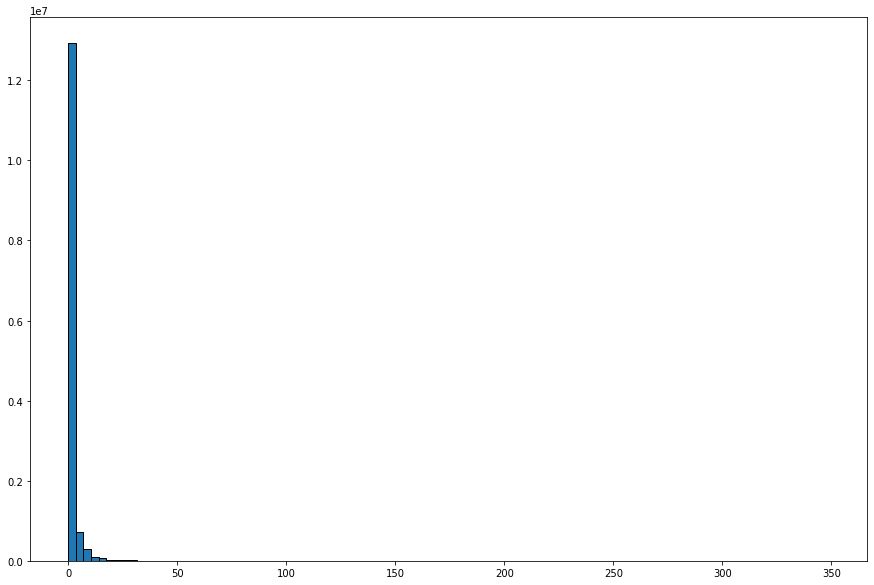

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(data['demand'], edgecolor='k', bins=100);

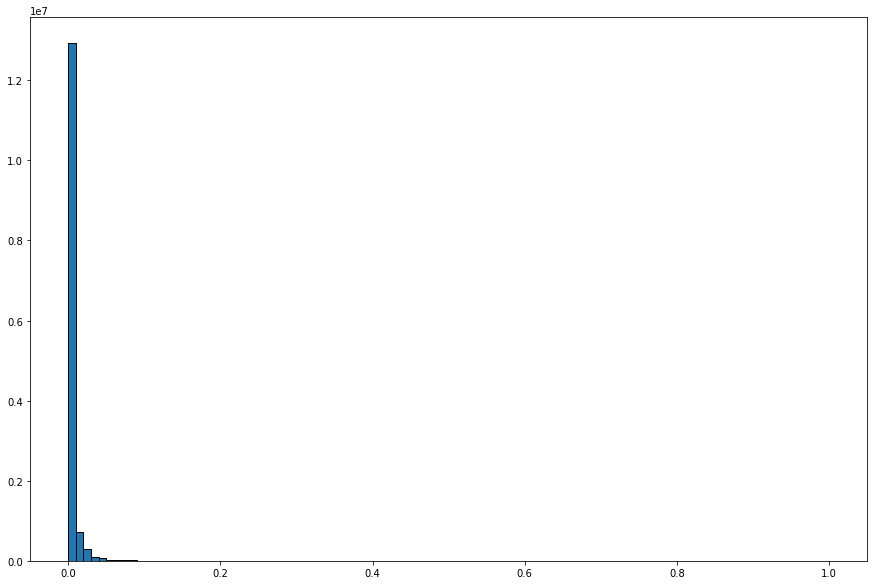

In [16]:
mm = MinMaxScaler()
temp_demand = np.array(data['demand']).reshape(-1, 1)
min_maxed_demand = mm.fit_transform(temp_demand)
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(min_maxed_demand, edgecolor='k', bins=100);

In [17]:
# Viewing the final dataset header
data.head()

,id,item_id,day,demand,part,date,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
0,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1476,7,train,2015-02-12,0,1,1,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,FOODS_3_635_WI_2_validation,FOODS_3_635,d_1476,8,train,2015-02-12,0,1,1,0.939941,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,FOODS_3_636_WI_2_validation,FOODS_3_636,d_1476,12,train,2015-02-12,0,1,1,3.500000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,FOODS_3_637_WI_2_validation,FOODS_3_637,d_1476,1,train,2015-02-12,0,1,1,2.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,FOODS_3_638_WI_2_validation,FOODS_3_638,d_1476,0,train,2015-02-12,0,1,1,1.450195,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


# Part 4. Analyzing Time Series

- double / triple exponential smoothing
- analyze stationarity
- SARIMA model for prediction
- Gradient Boosting for prediction

In [18]:
data[data['id'] == 'FOODS_3_634_WI_2_validation'].head()

,id,item_id,day,demand,part,date,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
0,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1476,7,train,2015-02-12,0,1,1,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
30490,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1477,3,train,2015-02-13,0,1,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
60980,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1478,6,train,2015-02-14,0,0,1,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
91470,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1479,6,train,2015-02-15,0,1,1,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
121960,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1480,7,train,2015-02-16,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [19]:
data[(data['id'] == 'FOODS_3_634_WI_2_validation') & (data['demand'] > 0) & (data['part'] == 'train')].head()

,id,item_id,day,demand,part,date,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
0,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1476,7,train,2015-02-12,0,1,1,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
30490,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1477,3,train,2015-02-13,0,1,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
60980,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1478,6,train,2015-02-14,0,0,1,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
91470,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1479,6,train,2015-02-15,0,1,1,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
121960,FOODS_3_634_WI_2_validation,FOODS_3_634,d_1480,7,train,2015-02-16,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [20]:
# Select training and validation data only for analysis
# Selecting only 1 item for testing: FOODS_3_634_WI_2
# df = data[(data['date'] <= '2016-04-24') & (data['id'] == 'FOODS_3_634_WI_2_validation') & (data['demand'] > 0) & (data['demand'] <= 15)]
df = data[(data.date >= '2015-10-20') & \
         (data['date'] <= '2016-04-24') & \
         (data['id'] == 'FOODS_3_634_WI_2_validation')\
          ]
         # & (data['demand'] > 0)] #& (data['demand'] <= 15)]

# Selecting only a few columns for analysis and training

df = df.loc[:, ~df.columns.isin(['id', 'item_id', 'day', 'part'])]
df.set_index('date', inplace=True)



# df = df.loc[:, ~df.columns.isin(['id', 'item_id', 'date', 'part'])]
# df.set_index('day', inplace=True)

df.head()

,demand,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-10-20,2,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2015-10-21,0,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2015-10-22,4,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2015-10-23,3,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2015-10-24,3,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


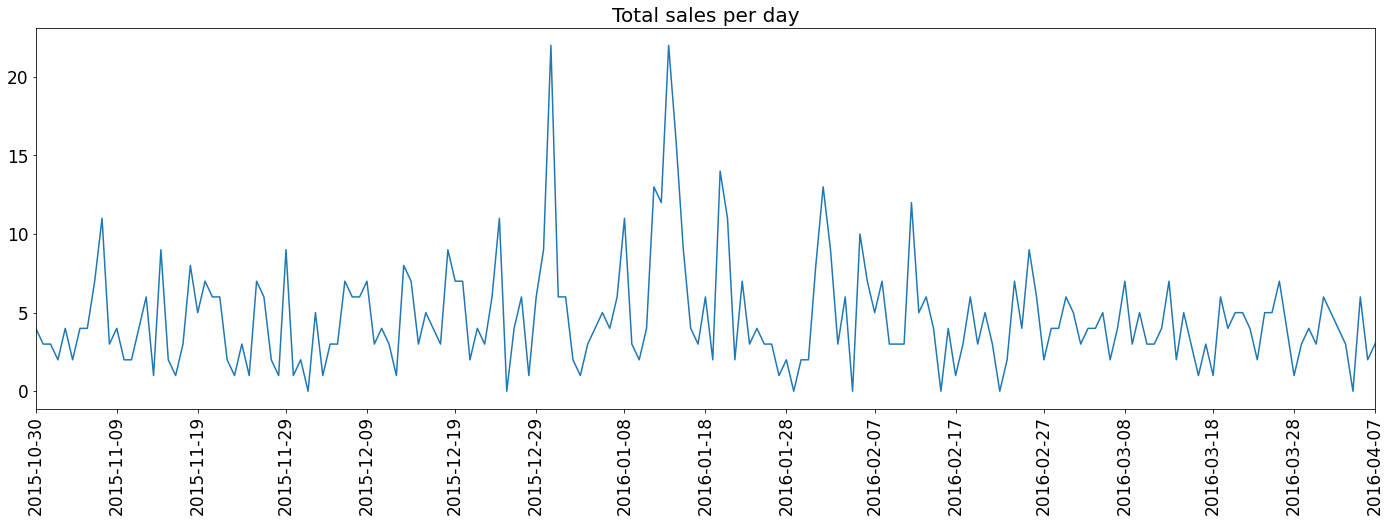

In [21]:
fig, ax = plt.subplots(figsize=(24,7))

ax.plot(df.demand)
ax.set_title('Total sales per day', fontsize=20)

# print(ax.get_xticks())
TICKS = np.arange(np.datetime64(min(df.index.values)), 
                             np.datetime64(max(df.index.values)), 10)

xmin, xmax = ax.get_xlim()
custom_ticks = np.linspace(xmin, xmax, len(TICKS), dtype=int)
ax.set_xticks(custom_ticks)

ax.set_xticklabels(TICKS,
                   rotation=90)

ax.tick_params(labelsize=17)

ax.set_xlim(custom_ticks[1], custom_ticks[-2]);

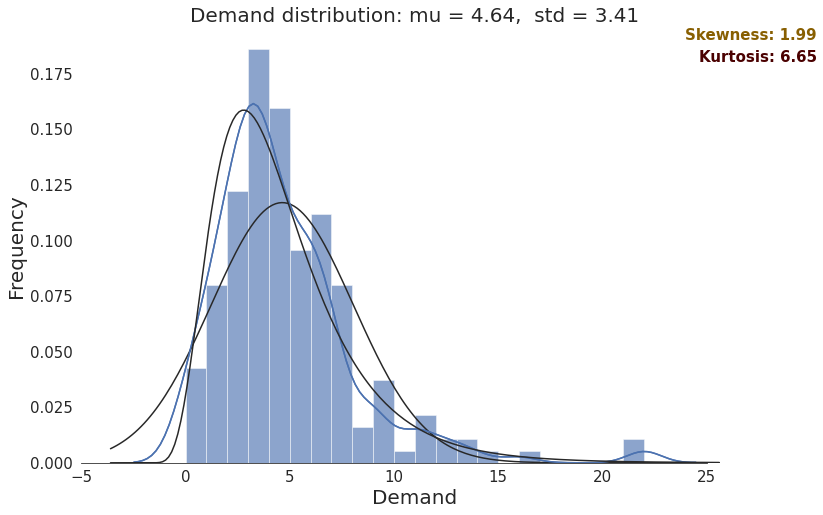

In [22]:
# Viewing distribution information for the variable "demand"
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(12, 8))

# Fit a normal distribution
mu, std = norm.fit(df['demand'])

# Checking the frequency distribution of the variable "demand"
sns.distplot(df['demand'], color="b", fit = stats.norm)
sns.distplot(df['demand'], color="b", fit = stats.lognorm)

ax.xaxis.grid(False)
ax.set_ylabel("Frequency", fontsize=20)
ax.set_xlabel("Demand", fontsize=20)
ax.set_title("Demand distribution: mu = %.2f,  std = %.2f" % (mu, std), fontsize=20)
sns.despine(trim=True, left=True)

# Adding Skewness and Kurtosis
ax.text(x=1.1, y=1, transform=ax.transAxes, s=f"Skewness: {df['demand'].skew():.2f}",\
        fontweight='demibold', fontsize=15, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=1.1, y=0.95, transform=ax.transAxes, s=f"Kurtosis: {df['demand'].kurt():.2f}",\
        fontweight='demibold', fontsize=15, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
ax.tick_params(labelsize=15)
plt.show()

## 4.1. Metrics for forecasting
- Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.


- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## 4.2. Move, smoothe, evaluate

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [24]:
def moving_average(series, n):
    '''
        calculates average of last n observations
    '''
    return np.average(series[-n:])

moving_average(df.demand, 28)

3.7857142857142856

Unfortunately, we cannot make predictions far in the future - in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [25]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    '''
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    '''
    rolling_mean = series.rolling(window=window).mean()

    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title(f"Moving average\n window size = {window}", fontsize=20)
    ax.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        ax.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        ax.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            ax.plot(anomalies, "ro", markersize=10)
        
    ax.plot(series[window:], label="Actual values")
    ax.legend(loc='best')
    
    TICKS = np.arange(np.datetime64(min(df.index.values)), 
                             np.datetime64(max(df.index.values)), 10)
    xmin, xmax = ax.get_xlim()
    custom_ticks = np.linspace(xmin, xmax, len(TICKS), dtype=int)
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(TICKS,
                       rotation=90)
    ax.set_xlim(custom_ticks[1], custom_ticks[-2]);
    
    ax.tick_params(labelsize=17)

    # TICKS = ax.get_xticks()
    # ax.set_xlim(TICKS[1], TICKS[-2]);

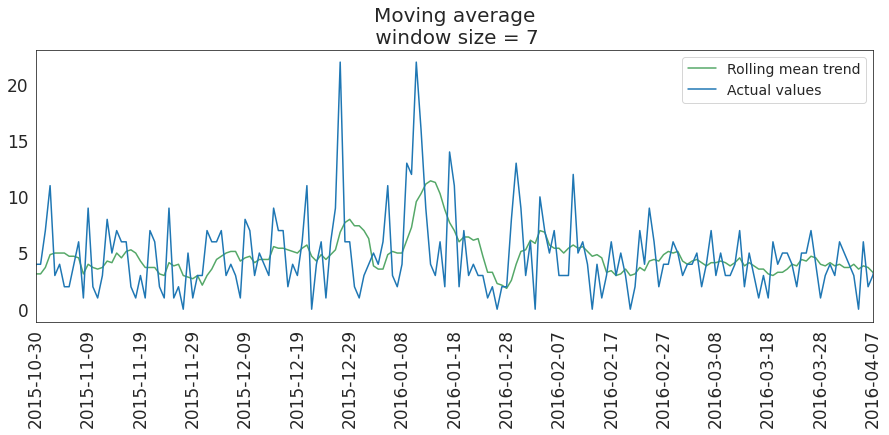

In [26]:
# smoothing with a 7-day window
plotMovingAverage(df['demand'], 7)

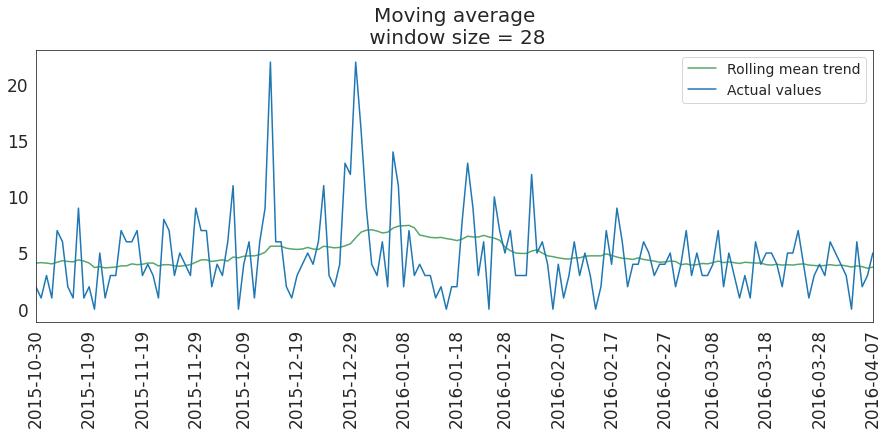

In [27]:
# smoothing with a 28-day window
plotMovingAverage(df['demand'], 28)

# When we apply smoothing to the data, we can clearly see the sales dynamics in the period.

We can also plot confidence intervals

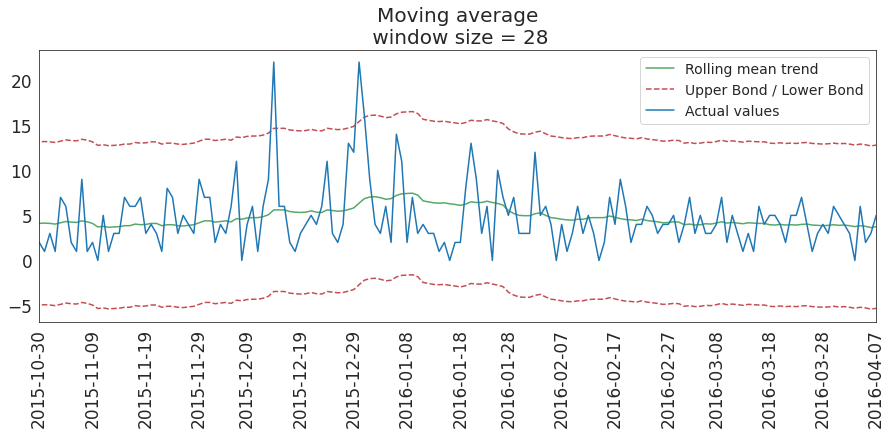

In [28]:
plotMovingAverage(df['demand'], 28, plot_intervals=True)

**Weighted average** is a simple modification to the moving average. The weights sum up to `1` with larger weights assigned to more recent observations.


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [29]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [30]:
weighted_average(df['demand'], [0.6, 0.3, 0.1])

4.9

## 4.3 Exponential smoothing

Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for **[exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)** that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function – we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [31]:
def exponential_smoothing(series, alpha):
    '''
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    '''
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [99]:
def plotExponentialSmoothing(series, alphas):
    '''
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
    '''
    # with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize=(15,7))
    for alpha in alphas:
        ax.plot(exponential_smoothing(series, alpha), label=f"Alpha {alpha:.2f}",
            color=next(color_cycle), lw=3)
    ax.plot(series.values, "c", label = "Actual", alpha=.8, lw=3)
    ax.legend(loc="best")
    ax.set_title("Exponential Smoothing")

    TICKS = np.arange(np.datetime64(min(df.index.values)), 
                            np.datetime64(max(df.index.values)), 10)
    xmin, xmax = ax.get_xlim()
    custom_ticks = np.linspace(xmin, xmax, len(TICKS), dtype=int)
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(TICKS,
                    rotation=90)
    ax.set_xlim(custom_ticks[1], custom_ticks[-2])
    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=17)
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=17)

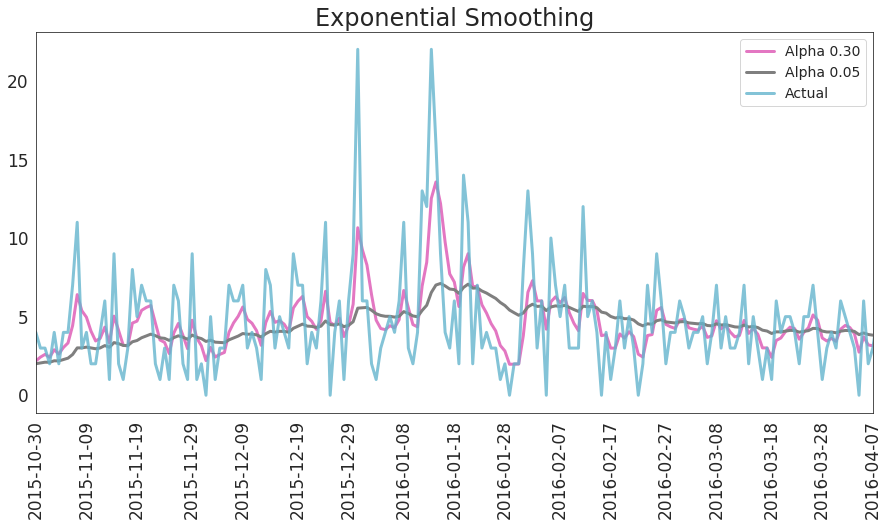

In [100]:
plotExponentialSmoothing(df['demand'], [0.3, 0.05])

## 4.4 Double exponential smoothing

Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [34]:
def double_exponential_smoothing(series, alpha, beta):
    '''
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    '''
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [101]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    '''
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    '''
    
    with plt.style.context('seaborn-white'):
        fig, ax = plt.subplots(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                ax.plot(double_exponential_smoothing(series, alpha, beta),
                        label=f"Alpha: {alpha:.3f}, beta: {beta:.3f}")
        ax.plot(series.values, label = "Actual")
        ax.legend(loc="best")
        ax.axis('tight')
        ax.set_title("Double Exponential Smoothing")

        TICKS = np.arange(np.datetime64(min(df.index.values)), 
                            np.datetime64(max(df.index.values)), 10)
        xmin, xmax = ax.get_xlim()
        custom_ticks = np.linspace(xmin, xmax, len(TICKS), dtype=int)
        ax.set_xticks(custom_ticks)
        ax.set_xticklabels(TICKS,
                        rotation=90)
        ax.set_xlim(custom_ticks[1], custom_ticks[-2])

        plt.setp(ax.xaxis.get_majorticklabels(), fontsize=17)
        plt.setp(ax.yaxis.get_majorticklabels(), fontsize=17)

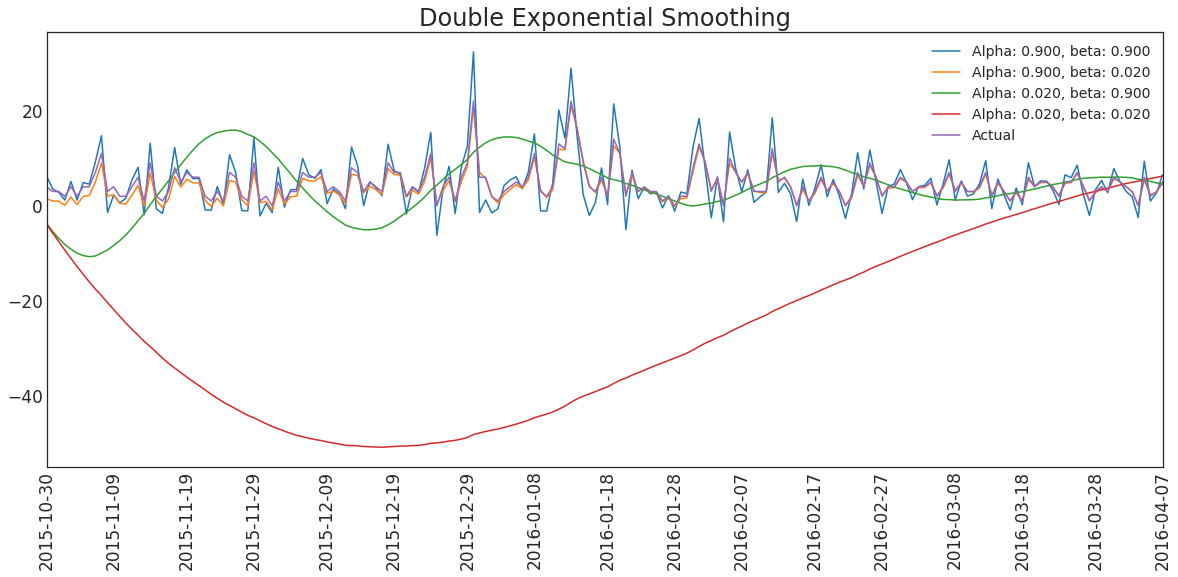

In [102]:
plotDoubleExponentialSmoothing(df['demand'],
                               alphas=[0.9, 0.02],
                               betas=[0.9, 0.02])

Now we have to adjust two parameters: alpha and beta. The first is responsible for smoothing the series around the trend, the second for smoothing the trend itself. The higher the values, the greater the weight of the most recent observations and the less smoothed the series will be.


### ----


Now we have to tune two parameters: $\alpha$ and $\beta$. The former is responsible for the series smoothing around the trend, the latter for the smoothing of the trend itself. The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be. Certain combinations of the parameters may produce strange results, especially if set manually. We'll look into choosing parameters automatically in a bit; before that, let's discuss triple exponential smoothing.

## Triple exponential smoothing a.k.a. Holt-Winters

We've looked at exponential smoothing and double exponential smoothing. This time, we're going into _triple_ exponential smoothing.

As you could have guessed, the idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

With this, let's write out a new system of equations:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. You can read more on how averaging works and how the initial approximation of the trend and seasonal components is done [here](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary $m$ future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$

where $T$ is the length of the season, $d$ is the predicted deviation. Other parameters were taken from triple exponential smoothing. You can read more about the method and its applicability to anomaly detection in time series [here](http://fedcsis.org/proceedings/2012/pliks/118.pdf).

In [37]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## 4.6 Time series cross validation

Before we start building a model, let's first discuss how to estimate model parameters automatically.

There is nothing unusual here; as always, we have to choose a loss function suitable for the task that will tell us how closely the model approximates the data. Then, using cross-validation, we will evaluate our chosen loss function for the given model parameters, calculate the gradient, adjust the model parameters, and so on, eventually descending to the global minimum.

You may be asking how to do cross-validation for time series because time series have this temporal structure and one cannot randomly mix values in a fold while preserving this structure. With randomization, all time dependencies between observations will be lost. This is why we will have to use a more tricky approach in optimizing the model parameters. I do not know if there's an official name to this, but on CrossValidated, where one can find all answers but the Answer to the Ultimate Question of Life, the Universe, and Everything, the proposed name for this method is "cross-validation on a rolling basis".

The idea is rather simple -- we train our model on a small segment of the time series from the beginning until some $t$ , make predictions for the next  $t+n$  steps, and calculate an error. Then, we expand our training sample to  $t+n$  value, make predictions from  $t+n$  until  $t+2∗n$, and continue moving our test segment of the time series until we hit the last available observation. As a result, we have as many folds as  $n$  will fit between the initial training sample and the last observation


https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Now, knowing how to set up cross-validation, we can find the optimal parameters for the Holt-Winters model. Recall that we have daily seasonality, hence the `slen=1` parameter. (в лекции было slen=24)


In [38]:
def timeseriesCVscore(params, series, loss_function=rmse, slen=28):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=2) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], 
                            slen=slen, 
                            alpha=alpha, 
                            beta=beta, 
                            gamma=gamma, 
                            n_preds=len(test))
        
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [39]:
%%time
new_data = df['demand']

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, 
               x0=x, 
               args=(new_data, mean_squared_error), 
               method="TNC", 
               bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 28 days
model = HoltWinters(new_data, 
                    slen=28, 
                    alpha=alpha_final, 
                    beta=beta_final, 
                    gamma=gamma_final, 
                    n_preds=28, 
                    scaling_factor=3)

model.triple_exponential_smoothing()

0.32939494449918805 0.006136546004838095 0.20698275677092048
CPU times: user 1.63 s, sys: 13.2 ms, total: 1.65 s
Wall time: 1.63 s


In [111]:
def plotHoltWinters(series, error_func=rmse, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(model.result, label = "Model")
    ax.plot(series.values, label = "Actual")
    
    #error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    #plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
#     error = rmse(series.values, model.result[:len(series)])
#     plt.title("RMSE: {0:.2f}".format(error))
    
    error = error_func(series.values, model.result[:len(series)])
    ax.set_title(f"{error_func.__name__.upper()}: {error:.2f}")
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        ax.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        ax.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        ax.plot(model.LowerBond, "r--", alpha=0.5)
        ax.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    ax.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    # ax.axvspan(len(series)-60, len(model.result), alpha=0.3, color='lightgrey')
    ax.axis('tight')
    ax.legend(loc="best", fontsize=15)
    
    TICKS = np.arange(np.datetime64(min(df.index.values)), 
                         np.datetime64(max(df.index.values)), 10)
    xmin, xmax = ax.get_xlim()
    custom_ticks = np.linspace(xmin, xmax, len(TICKS), dtype=int)
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(TICKS,
                       rotation=90)
    ax.set_xlim(custom_ticks[1], custom_ticks[-2])
    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=17)
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=17)
    

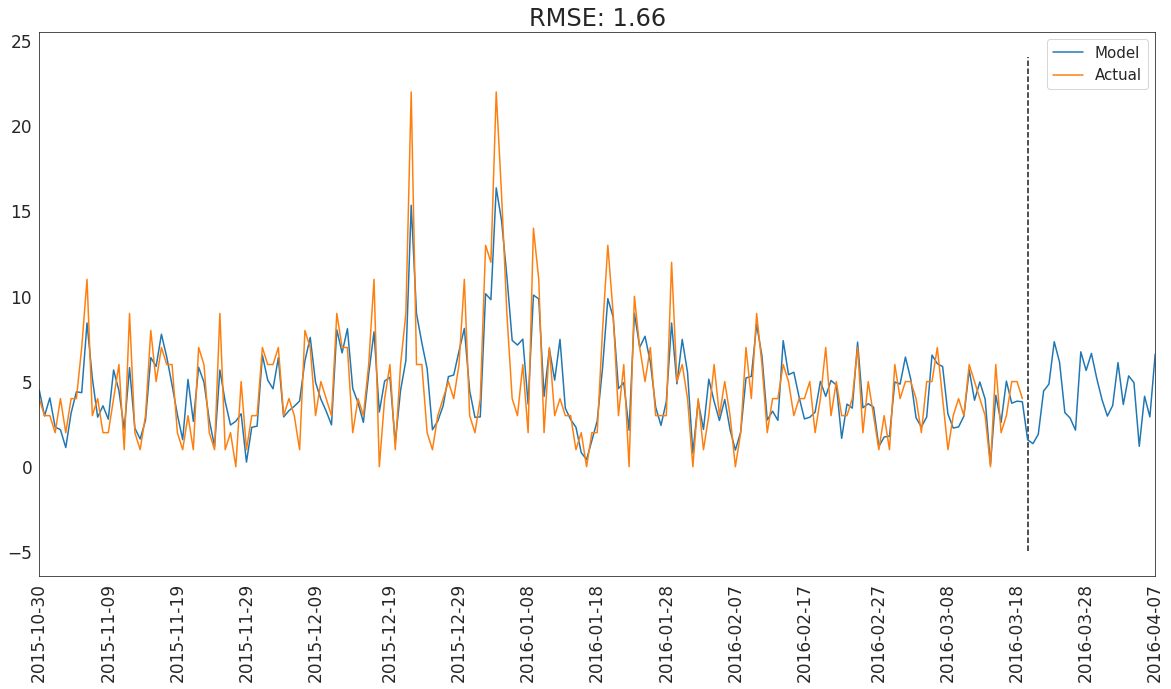

In [112]:
plotHoltWinters(df['demand'])

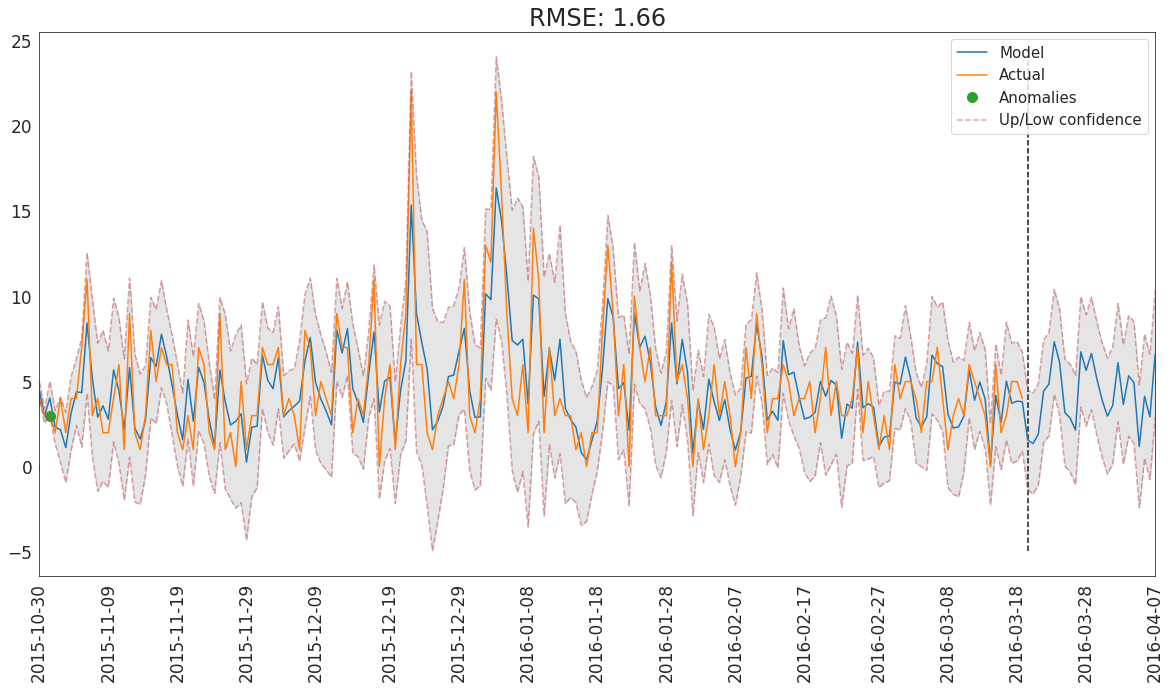

In [113]:
plotHoltWinters(df['demand'], plot_intervals=True, plot_anomalies=True)

Judging by the graphs, our model has successfully managed to approximate the initial time series, capturing daily seasonality, the general downward trend and even some anomalies. If you look at the deviations from the model, you can clearly see that the model reacts a lot to changes in the series structure, but then quickly returns the deviation to normal values, essentially "forgetting" the past. This model feature allows us to quickly create anomaly detection systems, even for noise in the series data, without spending a lot of time preparing the data and training the model.

Text(0.5, 1.0, "Brutlag's predicted deviation")

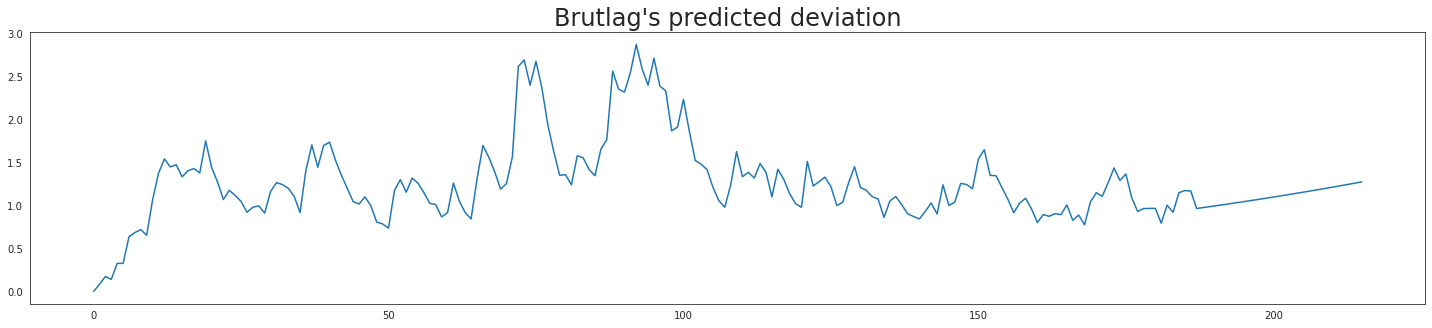

In [43]:
fig, ax = plt.subplots(figsize=(25,5))
ax.plot(model.PredictedDeviation)
ax.axis('tight')
ax.set_title("Brutlag's predicted deviation")

# xmin, xmax = ax.get_xlim()
# ax.set_xlim(0, xmax-10.25);

## 4.7 Econometric approach

### Stationarity
Before we start modeling, we should mention such an important property of time series: [stationarity](https://en.wikipedia.org/wiki/Stationary_process).

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity))The covariance function does not depend on time; it should only depend on the distance between observations. You can see this visually on the images in the post by Sean Abu (http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- The red graph below is not stationary because the mean increases over time.
<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- We were unlucky with the variance and see the varying spread of values over time

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time in the right chart

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

So why is stationarity so important? Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

So, in order to combat non-stationarity, we have to know our enemy, so to speak. Let's see how we can detect it. We will look at white noise and random walks to learn how to get from one to another for free.

## 4.8 Getting rid of non-stationarity and building SARIMA

Let's build an ARIMA model by walking through all the circles of hell stages of making a series stationary.

Here is the code to render plots.

In [44]:
def tsplot(y, lags=None):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context('bmh'):
        fig = plt.figure(figsize=(12, 7))
        
        gs = fig.add_gridspec(nrows=2, ncols=2, hspace=1)
        ts_ax = fig.add_subplot(gs[0, :])
        acf_ax = fig.add_subplot(gs[1, 0])
        pacf_ax = fig.add_subplot(gs[1, 1])
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        fig.tight_layout()
        
        plt.setp(ts_ax.xaxis.get_majorticklabels(), rotation=45, fontsize=12)

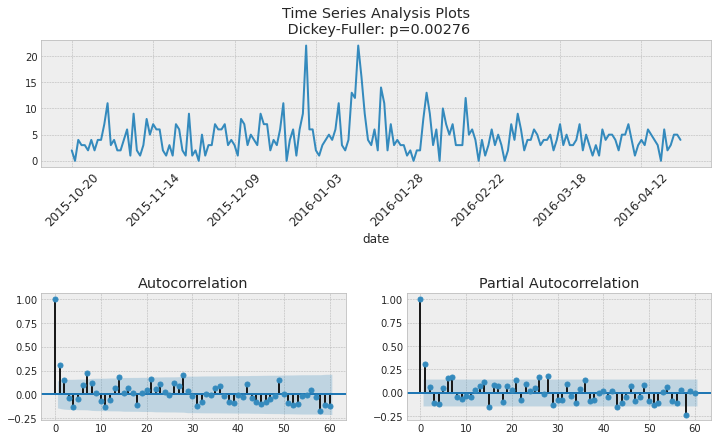

In [45]:
tsplot(df['demand'], lags=60)

Surprisingly, the initial series is stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. We can actually see this on the chart itself - we don't have a visible trend; therefore, the average is constant and the variation is practically stable. The only thing left is seasonality, which we have to deal with before modeling. To do this, we will use the "seasonal difference", which means a simple subtraction of the series from itself with a delay equal to the seasonal period.

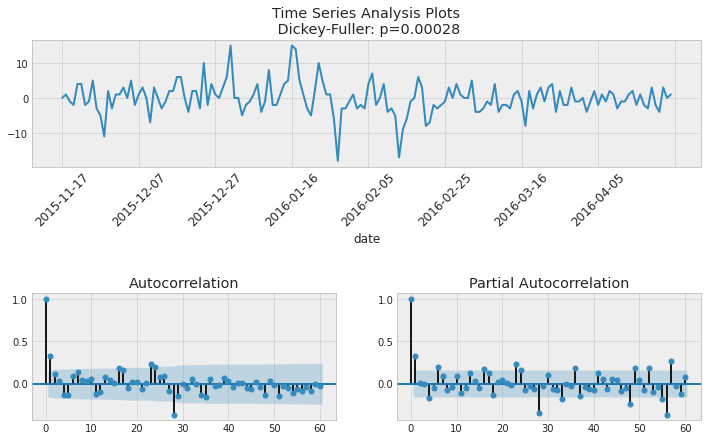

In [46]:
df_diff = df['demand'] - df['demand'].shift(28)
tsplot(df_diff[28:], lags=60)

It is now much better with the visible seasonality gone.

## 4.9 Família ARIMA

## ARIMA-family Crash-Course

We will explain this model by building up letter by letter. $SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

- $AR(p)$ - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as $p$. To determine the initial $p$, you need to look at the PACF plot and find the biggest significant lag after which **most** other lags become insignificant.
- $MA(q)$ - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as $q$. The initial value can be found on the ACF plot with the same logic as before. 

Let's combine our first 4 letters:

$AR(p) + MA(q) = ARMA(p, q)$

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

- $I(d)$ - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences. 

Adding this letter to the four gives us the $ARIMA$ model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

- $S(s)$ - this is responsible for seasonality and equals the season period length of the series

With this, we have three parameters: $(P, D, Q)$

- $P$ - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial $P$ should be 2.

- $Q$ - similar logic using the ACF plot instead.

- $D$ - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

Now that we know how to define the initial parameters, let's take a look at the final graph again and define the parameters:

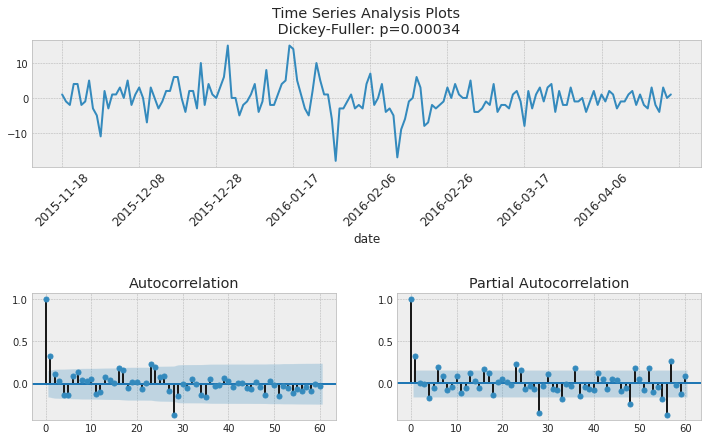

In [47]:
tsplot(df_diff[28+1:], lags=60)

- $p$ is most probably 4 ??? since it is the last significant lag on the PACF, after which, most others are not significant. 
- $d$ equals 1 because we had first differences
- $q$ should be somewhere around 4 as well as seen on the ACF
- $P$ might be 2, since 24-th and 56-th lags are somewhat significant on the PACF
- $D$ again equals 1 because we performed seasonal differentiation
- $Q$ is probably 1. The 28-th lag on ACF is significant while the 56-th is not.

In [48]:
# setting initial values and some bounds for them
# ps = range(2, 3)
ps = [1, 4]
# ds = [1, 2, 3] 
ds= [0, 1, 2] 
# qs = range(3)
qs = [1]

Ps = [2]
Ds = [0, 1, 2]
# Ds = [1, 2, 3] 
Qs = [1]
s = 28 # season length is still 28

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs, Ds, ds)
parameters_list = list(parameters)
len(parameters_list)

18

In [49]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df['demand'], 
                                            order=(param[0], param[5], param[1]), 
                                            seasonal_order=(param[2], param[4], param[3], s)).fit(disp=-1)
            # model=sm.tsa.statespace.SARIMAX(df['demand'], 
            #                                 order=(p=param[0], d=param[5], q=param[1]), 
            #                                 seasonal_order=(P=param[2], Q=param[4], D=param[3], s=s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [50]:
%%time
# result_table = optimizeSARIMA(parameters_list, d, D, s)
result_table = optimizeSARIMA(parameters_list, ds, Ds, s)


CPU times: user 19min 51s, sys: 6min 11s, total: 26min 2s
Wall time: 13min 13s


In [51]:
result_table.head()

,parameters,aic
0,"(1, 1, 2, 1, 2, 1)",828.209888
1,"(1, 1, 2, 1, 2, 0)",829.498668
2,"(4, 1, 2, 1, 2, 1)",831.268592
3,"(4, 1, 2, 1, 2, 0)",833.597288
4,"(4, 1, 2, 1, 2, 2)",856.501510


In [52]:
%%time
# set the parameters that give the lowest AIC
p, q, P, Q, D, d = result_table.parameters[0]
# ps, qs, Ps, Qs, Ds, ds
best_model=sm.tsa.statespace.SARIMAX(df['demand'], 
                                     order=(p, d, q),
                                     seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             demand   No. Observations:                  188
Model:             SARIMAX(1, 1, 1)x(2, 2, 1, 28)   Log Likelihood                -408.105
Date:                            Tue, 23 Jun 2020   AIC                            828.210
Time:                                    13:58:11   BIC                            845.461
Sample:                                10-20-2015   HQIC                           835.220
                                     - 04-24-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3139      0.094      3.337      0.001       0.130       0.498
ma.L1         -0.9841      0.118   

* We will inspect the model's residues.

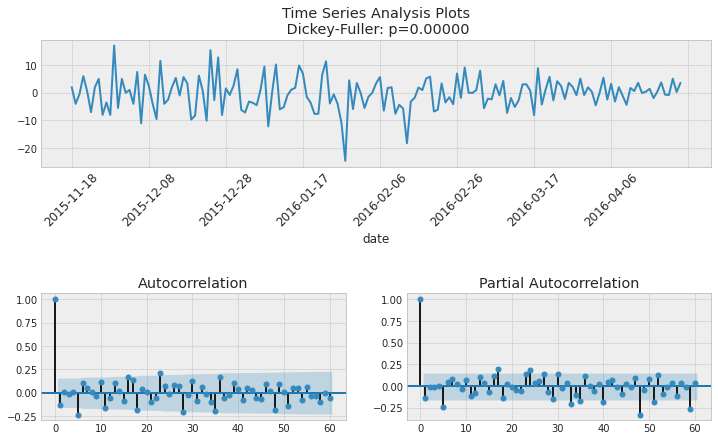

In [121]:
tsplot(best_model.resid[28+1:], lags=60)

It is clear that the residues are stationary and there is no apparent autocorrelation. We will make predictions using our model.

In [138]:
def plotSARIMA(series, model, n_steps, error_func=rmse):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    dfCopy = series.copy()
    
    dfCopy['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    dfCopy['arima_model'][:s+d] = np.NaN    
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = dfCopy.shape[0], end = dfCopy.shape[0]+n_steps)
    forecast = dfCopy['arima_model'].append(forecast)
    print(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = error_func(dfCopy['demand'][s+d:], dfCopy['arima_model'][s+d:])

    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_title(f"{error_func.__name__.upper()}: {error:.2f}")
    ax.plot(forecast.values, color='r', label="model")
    #plt.axvspan(dfCopy.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    ax.plot(dfCopy['demand'], label="actual")
    ax.legend(loc='best')


    TICKS = np.arange(np.datetime64(min(df.index.values)), 
                         np.datetime64(max(df.index.values)), 10)
    xmin, xmax = ax.get_xlim()
    custom_ticks = np.linspace(xmin, xmax, len(TICKS), dtype=int)
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(TICKS,
                       rotation=90)
    ax.set_xlim(custom_ticks[1], custom_ticks[-2])

    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=17)
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=17);

2015-10-20                  NaN
2015-10-21                  NaN
2015-10-22                  NaN
2015-10-23                  NaN
2015-10-24                  NaN
                         ...   
2016-05-19 00:00:00    1.350793
2016-05-20 00:00:00    2.262863
2016-05-21 00:00:00    3.563836
2016-05-22 00:00:00    1.002494
2016-05-23 00:00:00   -0.610078
Length: 217, dtype: float64


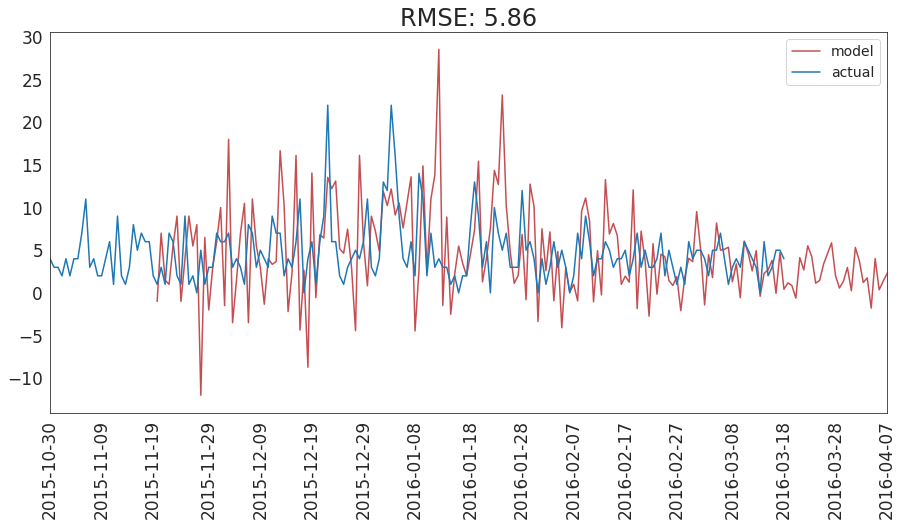

In [127]:
plotSARIMA(df, best_model, 28)

In the end, we got very good forecasts. Our model was off 2.96 (RMSE) on average, which is very, very good. However, the overall costs of preparing the data, preparing the series and selecting parameters may not be worth that precision.

# Part 5. Linear (and not quite) models for time series


Often, in my job, I have to build models with [*fast, good, cheap*](http://fastgood.cheap) as my only guiding principle. That means that some of these models will never be considered "production ready" as they demand too much time for data preparation (as in SARIMA) or require frequent re-training on new data (again, SARIMA) or are difficult to tune (good example - SARIMA). Therefore, it's very often much easier to select a few features from the existing time series and build a simple linear regression model or, say, a random forest. It is good and cheap.

This approach is not backed by theory and breaks several assumptions (e.g. Gauss-Markov theorem, especially for errors being uncorrelated), but it is very useful in practice and is often used in machine learning competitions.



## 5.1 Feature Extraction

The model needs features, and all we have is a 1-dimentional time series. What features can we extract? 
* Time series lags
* Window statistics:
    - Max/min value of series in a window
    - Average/median value in a window
    - Window variance
    - etc.
* Date and time features:
    - Minute of an hour, hour of a day, day of the week, and so on
    - Is this day a holiday? Maybe there is a special event? Represent that as a boolean feature
* Target encoding 
* Forecasts from other models (note that we can lose the speed of prediction this way)

Let's run through some of the methods and see what we can extract from our ads time series data.

## Time series lags

Shifting the series $n$ steps back, we get a feature column where the current value of time series is aligned with its value at time $t-n$. If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.

In [141]:
# Creating a copy of the initial datagrame to make various transformations 
new_df = df.copy()

new_df.head()

,demand,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-10-20,2,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2015-10-21,0,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2015-10-22,4,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2015-10-23,3,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2015-10-24,3,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [142]:
# Adding features considering the demand delay of 7 to 28 days
# Adding the lag of the target variable from 7steps back up to 28

for i in range(7, 29):
    new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

In [143]:
new_df.tail()

,demand,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-20,2,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0
2016-04-21,3,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0
2016-04-22,5,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0
2016-04-23,5,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,4.0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0
2016-04-24,4,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,3.0,4.0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0


Great, we have generated a dataset here. Why do we not now train a model? 

In [144]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [145]:
def timeseries_train_test_split(X, y, test_size):
    '''
    Perform train-test split with respect to time series structure
    '''
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test  = X.iloc[test_index:]
    y_test  = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [146]:
from sklearn.model_selection import train_test_split

In [147]:
new_df.head()

,demand,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-10-20,2,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-21,0,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-22,4,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-23,3,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-24,3,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
y = new_df.dropna()['demand']
X = new_df.dropna().drop(['demand'], axis=1)

In [151]:
def timeseries_train_test_split(X, y, test_size):
    '''
    Perform train-test split with respect to time series structure
    '''
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test  = X.iloc[test_index:]
    y_test  = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

# reserve 10% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [152]:
print(f"y_train shape: {X_train.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (144, 60)
y_test shape: (16,)


In [153]:
# machine learning in two lines
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [163]:
def plotModelResults(model, error_func=rmse, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(y_test.values, label="actual", linewidth=2.0)
    ax.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        ax.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        ax.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            ax.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = error_func(y_test, prediction)
    ax.set_title(f"{error_func.__name__.upper()}: {error:.2f}")
    ax.legend(loc="best")
    
    fig.tight_layout()

    # TICKS = np.arange(np.datetime64(min(df.index.values)), 
    #                      np.datetime64(max(df.index.values)), 10)
    # xmin, xmax = ax.get_xlim()
    # custom_ticks = np.linspace(xmin, xmax, len(TICKS), dtype=int)
    # ax.set_xticks(custom_ticks)
    # ax.set_xticklabels(TICKS,
    #                    rotation=90)
    # ax.set_xlim(custom_ticks[1], custom_ticks[-2])
    ax.set_xlim(ax.get_xticks()[1], ax.get_xticks()[-2])

    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=17)
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=17);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    fig, ax = plt.subplots(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    ax.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')


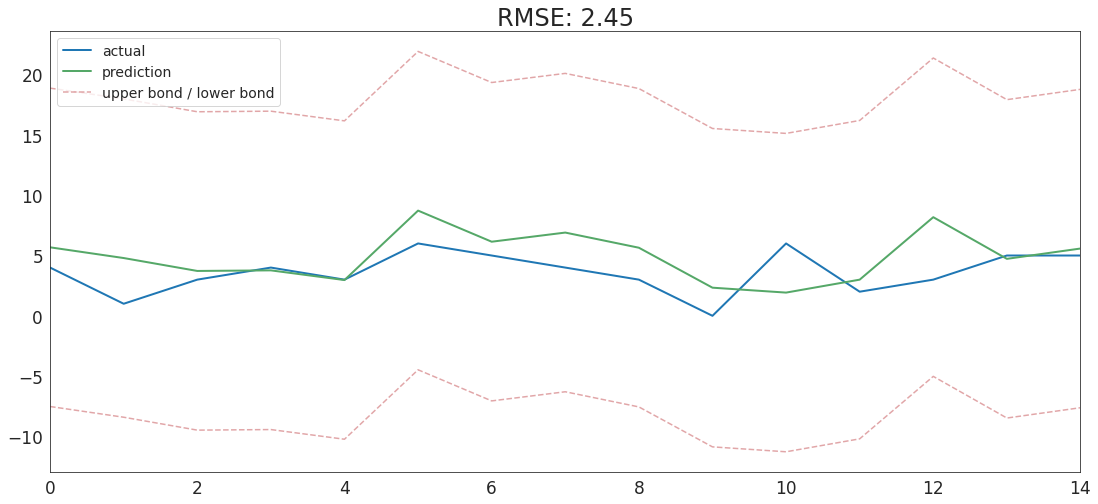

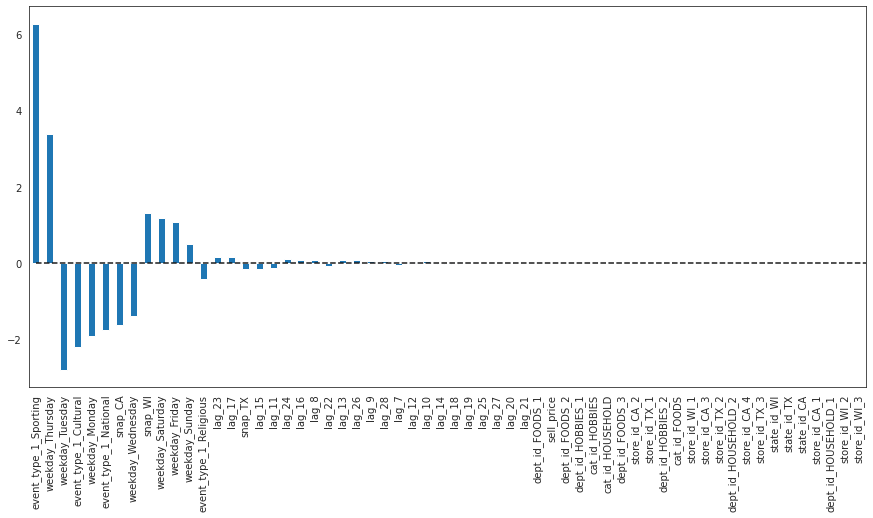

In [164]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Simple lags and linear regression gave us distant forecasts of SARIMA in terms of quality. As there are many unnecessary features, we will do the Feature Selection shortly. For now, let's continue engineering!

* We will add some date features. To do this, we need to transform the date to `datetime` format.

In [68]:
new_df.index = pd.to_datetime(new_df.index)
new_df["day"] = new_df.index.day
new_df["weekday"] = new_df.index.weekday
new_df['is_weekend'] = new_df.weekday.isin([5,6])*1
new_df.tail()

,demand,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,day,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-20,2,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0,20,2,0
2016-04-21,3,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,21,3,0
2016-04-22,5,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,22,4,0
2016-04-23,5,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,4.0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,23,5,1
2016-04-24,4,0,0,0,3.980469,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,3.0,4.0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,24,6,1


We can visualize the resulting features.

In [70]:
scaler = StandardScaler()

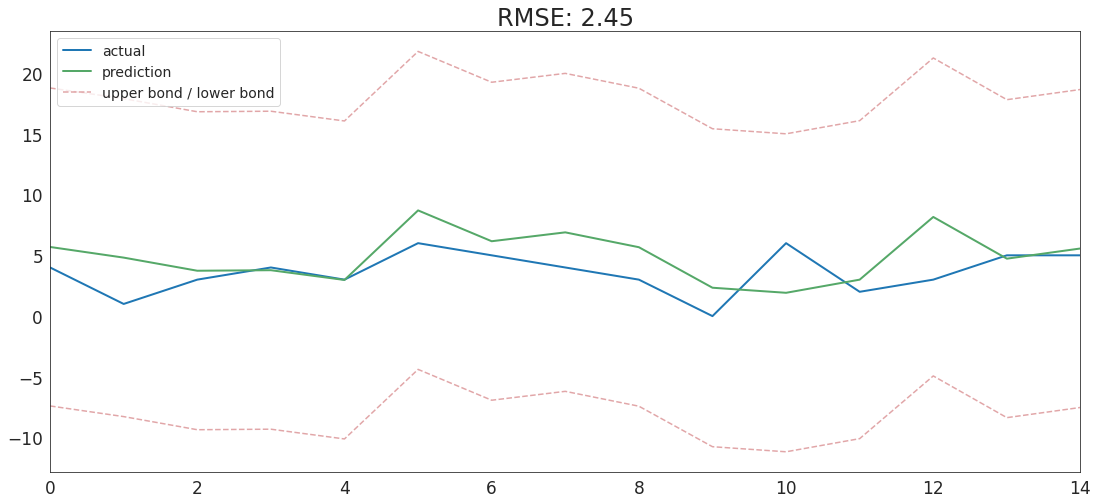

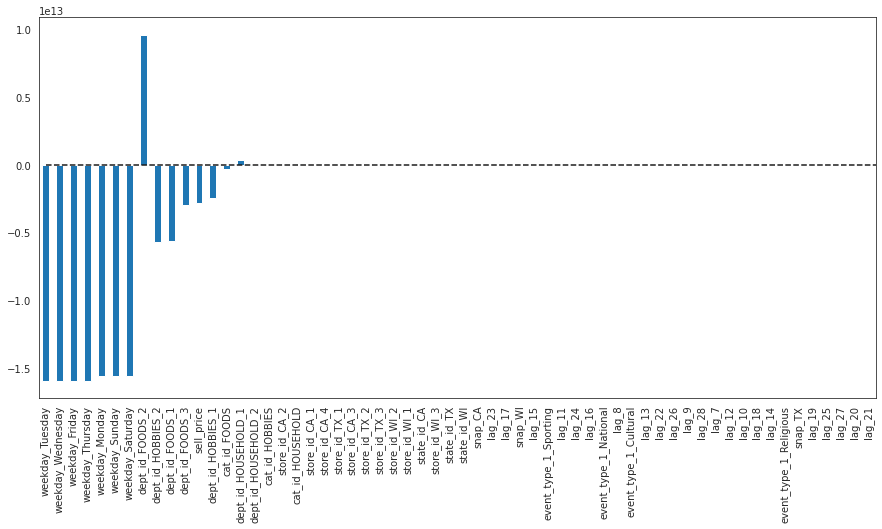

In [166]:
X = new_df.dropna().drop(['demand'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

The error remained the same

## 5.3 Target encoding

I'd like to add another variant for encoding categorical variables: encoding by mean value. If it is undesirable to explode a dataset by using many dummy variables that can lead to the loss of information and if they cannot be used as real values because of the conflicts like "0 hours < 23 hours", then it's possible to encode a variable with slightly more interpretable values. The natural idea is to encode with the mean value of the target variable. In our example, every day of the week and every hour of the day can be encoded by the corresponding average number of ads watched during that day or hour. It's very important to make sure that the mean value is calculated over the training set only (or over the current cross-validation fold only) so that the model is not aware of the future.

In [167]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
# average_day = code_mean(new_df, 'day', "demand") #? keyerror `day`
# fig, ax = plt.subplots(figsize=(12, 5))
# ax.set_title("Daily average demand")
# pd.DataFrame.from_dict(average_day, orient='index')[0].plot();

Finally, we are going to combine all the transformations into a single function.

In [177]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    new_df = df.copy()

    # lags of series
    for i in range(7, 29):
        new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

    # datetime features
    new_df.index = pd.to_datetime(new_df.index)
    new_df["day"] = new_df.index.day
    new_df["weekday"] = new_df.index.weekday
    new_df['is_weekend'] = new_df.weekday.isin([5,6])*1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(new_df.dropna())*(1-test_size))
        new_df['weekday_average'] = list(map(code_mean(new_df[:test_index], 'weekday', "demand").get, new_df['weekday']))
        new_df["day_average"] = list(map(code_mean(new_df[:test_index], 'day', "demand").get, new_df['day']))

        # from encoded variables 
        new_df.drop(["day", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = new_df.dropna()['demand']
    X = new_df.dropna().drop(['demand'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

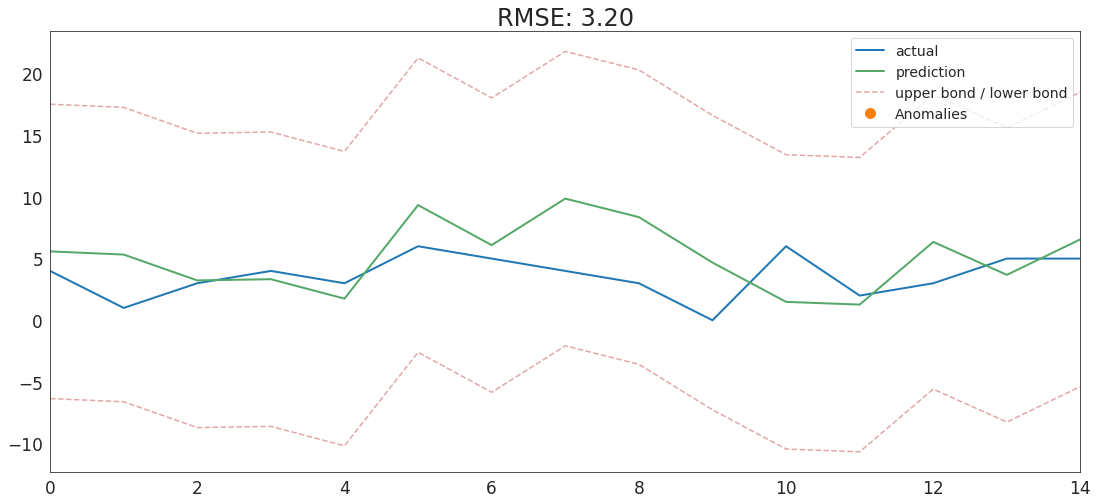

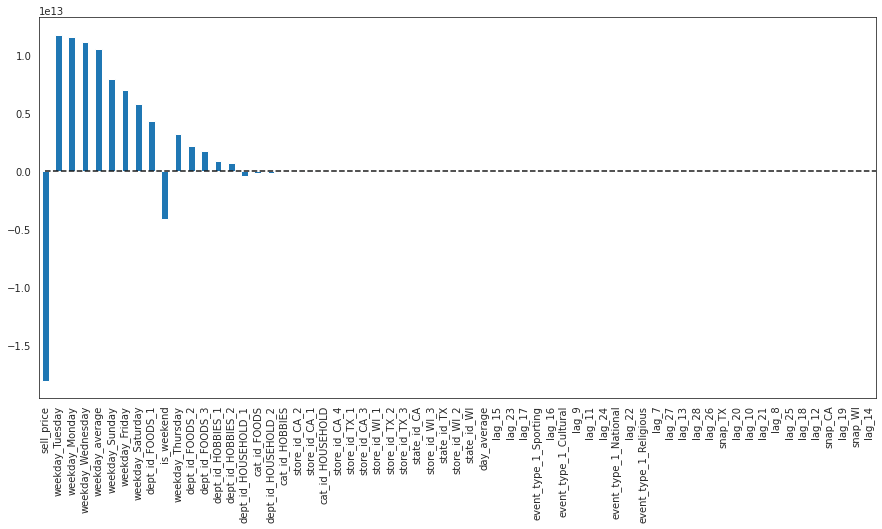

In [178]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

Apparently we see Overfitting! Some features played such a negative role in the training data set that the model decided to concentrate all its strengths on it. As a result, the quality of the forecast has declined. This problem can be solved in several ways; for example, we can calculate the target encoding not for the entire training set, but for some windows. In this way, the encodings of the last observed window will probably better describe the current state of the series. Alternatively, we can simply dispose of it manually, as we are sure that it makes things worse in this case.

In [179]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5.4 Regularization and feature selection  

As we already know, not all features are equally healthy -- some may lead to overfitting while others should be removed. Besides manual inspection, we can apply regularization. Two of the most popular regression models with regularization are Ridge and Lasso regressions. They both add some more constrains to our loss function. 

In the case of Ridge regression, those constraints are the sum of squares of the coefficients multiplied by the regularization coefficient. The bigger the coefficient a feature has, the bigger our loss will be. Hence, we will try to optimize the model while keeping the coefficients fairly low. 

As a result of this $L2$ regularization, we will have higher bias and lower variance, so the model will generalize better (at least that's what we hope will happen).

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, during the optimization process, coefficients of unimportant features may become zeroes, which allows for automated feature selection. This regularization type is called $L1$. 

First, let's make sure that we have features to drop and that the data has highly correlated features.

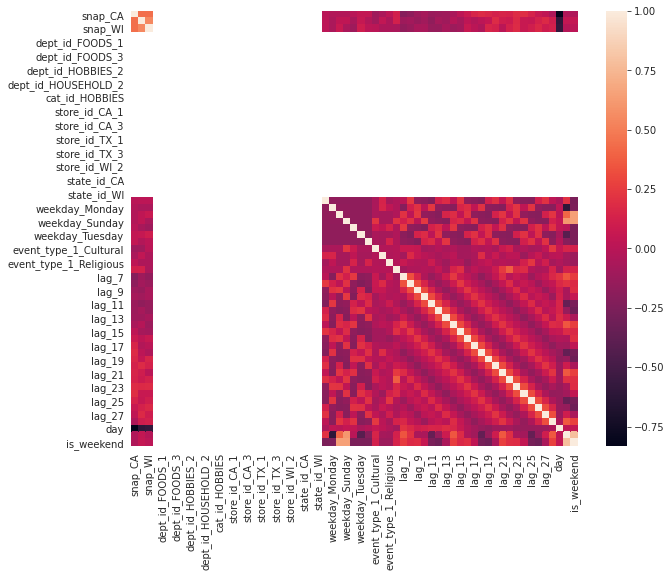

In [180]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(X_train.corr(), axes=ax);
# plt.setp(ax.xaxis.get_majorticklabels(),fontsize=8)
# plt.setp(ax.yaxis.get_majorticklabels(),fontsize=8)


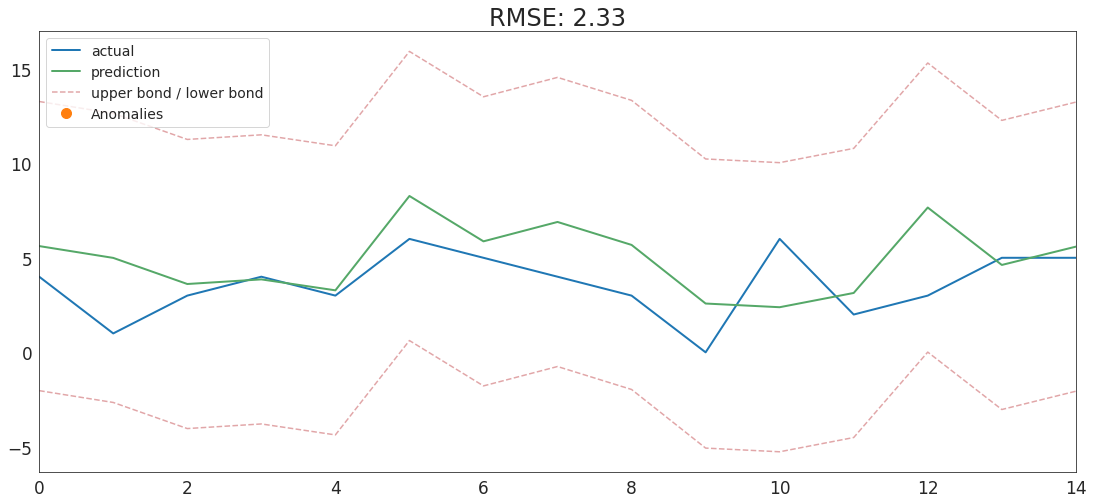

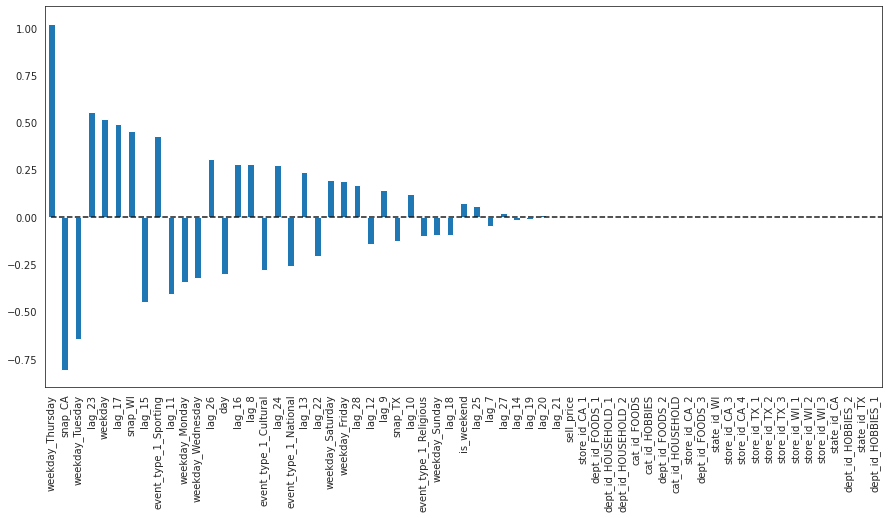

In [181]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(ridge)

We can clearly see that some coefficients are getting closer and closer to zero (although they never reach it) as their importance in the model decreases.

In [ ]:
# lasso = LassoCV(cv=tscv)
# lasso.fit(X_train_scaled, y_train)

# plotModelResults(lasso, 
#                  X_train=X_train_scaled, 
#                  X_test=X_test_scaled, 
#                  plot_intervals=True, 
#                  plot_anomalies=True)
# plotCoefficients(lasso)

The Lasso regression turned out to be more conservative; removed some important lag features which worsened the quality of the forecast.

# Part 6. XGBoost e LightGBM

In [173]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

[15:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

[15:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


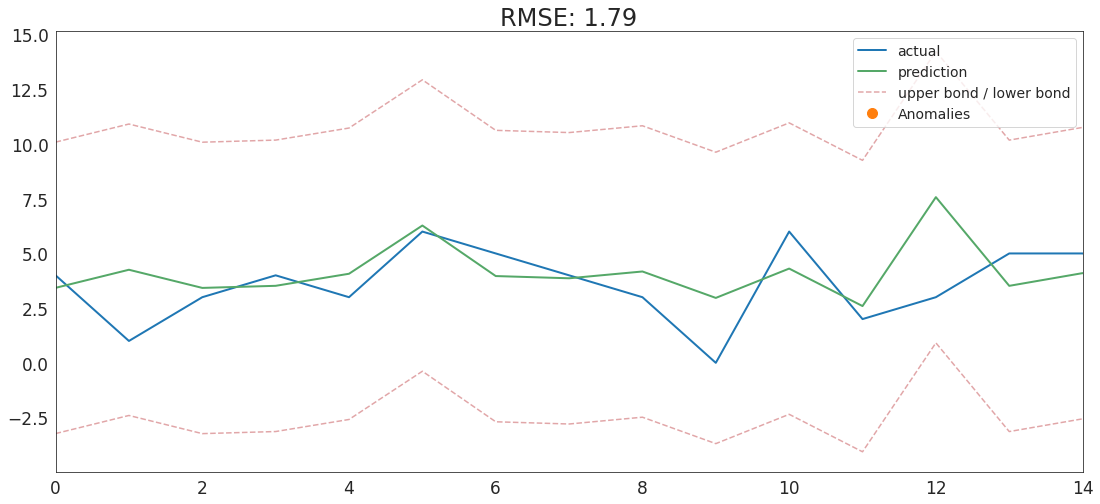

In [174]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)

In [82]:
from lightgbm import LGBMRegressor 

lgb = LGBMRegressor()
lgb.fit(X_train_scaled, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

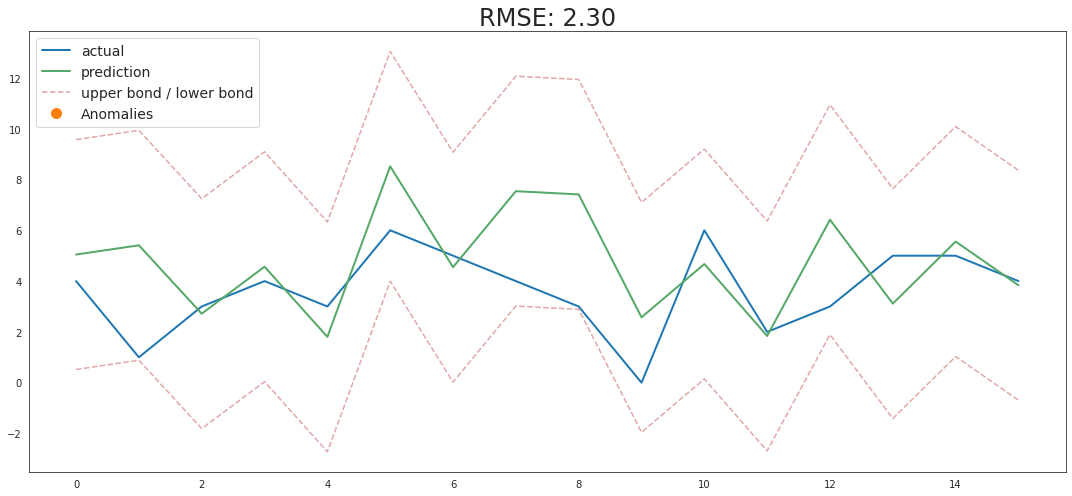

In [83]:
plotModelResults(lgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)